In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')

In [2]:
texts, labels = [], []

for line in open('./sentiment labelled sentences/amazon_cells_labelled.txt'):
    text, label = line.strip('\n').split('\t')
    texts.append(text)
    labels.append(int(label))

In [6]:
!pip install mlxtend

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = texts
y = labels

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

C:\Users\Tom\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from mlxtend.preprocessing import DenseTransformer
from sklearn.svm import SVC


model = Pipeline(
[
    ('vect', TfidfVectorizer()), # Позволяет преобразовать текст в набор признаков, в значении каждого из которых стоит нормированная на число документов частота соответствующего слова
    ('dense', DenseTransformer()), # TfidfVectorizer возвращает SparseMatrix. Нам нужно преобразовать её в Dense, чтобы передать классификатору
    ('svm', SVC(kernel='linear'))
])

In [21]:
clf = model.fit(X_train, y_train)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [84]:
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test) 
cm = confusion_matrix(y_test, y_pred) 
print(accuracy)
cm

0.8533333333333334


array([[129,  17],
       [ 27, 127]], dtype=int64)

In [29]:
print (model.get_params()['vect'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


In [114]:
parameter_candidates = {
    #'vect__min_df': [0.01, 0.05],
    'vect__max_df': [0.8, 0.9, 1],
    'svm__C': [0.001, 0.1, 0.5, 1.0, 10., 100., 1000.],
    'svm__kernel': ['linear', 'rbf', 'poly']
}

In [115]:
gs = GridSearchCV(model, param_grid=parameter_candidates, cv=5, scoring='accuracy',n_jobs=-1)#verbose=0

gs.fit(X_train, y_train)   

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': [0.8, 0.9, 1], 'svm__C': [0.001, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0], 'svm__kernel': ['linear', 'rbf', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [122]:
y_pred = gs.best_estimator_.predict(X_test)
print(gs.best_score_)
accuracy = gs.score(X_test, y_test) # чем это отличается от строки выше?
print(accuracy)
confusion_matrix(y_test, y_pred) # почему такая же матрица и такая же точность получилась, как и выше?

0.8028571428571428
0.8533333333333334


array([[129,  17],
       [ 27, 127]], dtype=int64)

In [99]:
import numpy as np
from sklearn.model_selection import validation_curve

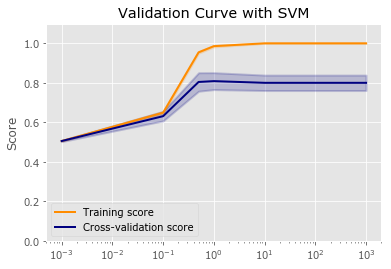

In [119]:
param_range = [0.001, 0.1, 0.5, 1.0, 10., 100., 1000.]
train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_range=param_range,param_name="svm__C",
    cv=10, scoring="accuracy", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
#plt.xlabel("$\svm__C$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [125]:
from sklearn.linear_model import LogisticRegression

model_lr = Pipeline(
[
    ('vect', TfidfVectorizer()), 
    ('dense', DenseTransformer()),
    ('lr', LogisticRegression())
])

In [128]:
model_lr = model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred) 

In [130]:
accuracy = model_lr.score(X_test, y_test) 
cm = confusion_matrix(y_test, y_pred) 
print(accuracy) # SVM немного получше
cm

0.8233333333333334


array([[124,  22],
       [ 31, 123]], dtype=int64)